# Road Segmentation in Aerial Images using U‑Net

In [ ]:
# Install kaggle
!pip install kaggle



In [ ]:
# Upload the kaggle.json file
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alaashorbaji","key":"dd3b4b8c063a3d84fb12e92072782756"}'}

In [ ]:
# ✅ Step 3: Move kaggle.json and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d balraj98/massachusetts-roads-dataset
!unzip massachusetts-roads-dataset.zip -d /content/road_data

Dataset URL: https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset
License(s): other
 99% 5.72G/5.76G [00:18<00:00, 623MB/s]
100% 5.76G/5.76G [00:18<00:00, 338MB/s]
Archive:  massachusetts-roads-dataset.zip
  inflating: /content/road_data/label_class_dict.csv  
  inflating: /content/road_data/metadata.csv  
  inflating: /content/road_data/tiff/test/10378780_15.tiff  
  inflating: /content/road_data/tiff/test/10828720_15.tiff  
  inflating: /content/road_data/tiff/test/11128870_15.tiff  
  inflating: /content/road_data/tiff/test/11278840_15.tiff  
  inflating: /content/road_data/tiff/test/11728825_15.tiff  
  inflating: /content/road_data/tiff/test/12328750_15.tiff  
  inflating: /content/road_data/tiff/test/15928855_15.tiff  
  inflating: /content/road_data/tiff/test/16078870_15.tiff  
  inflating: /content/road_data/tiff/test/17878735_15.tiff  
  inflating: /content/road_data/tiff/test/17878780_15.tiff  
  inflating: /content/road_data/tiff/test/17878885_15.tiff  
  inf

# Load and Display Sample Image and Mask

In [ ]:
import os

# List contents of the tiff folder
tiff_path = "/content/road_data/tiff"
print("Contents of tiff folder:")
print(os.listdir(tiff_path))


Contents of tiff folder:
['train', 'val_labels', 'val', 'test_labels', 'test', 'train_labels']


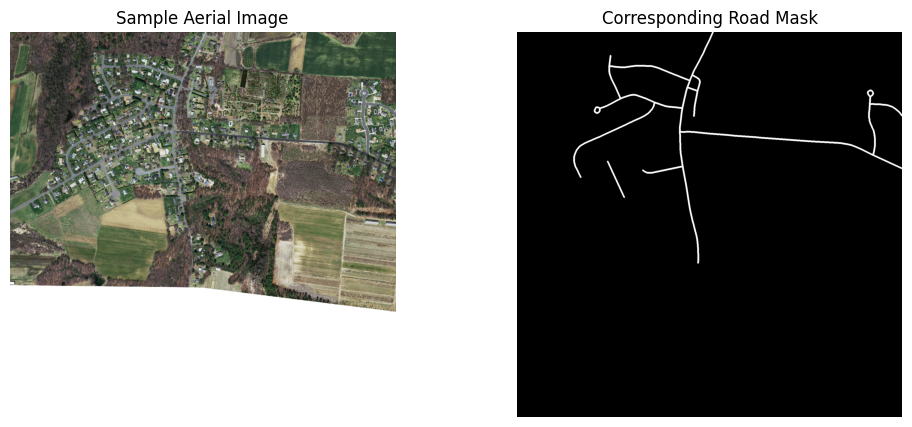

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define correct image and mask directories
image_dir = "/content/road_data/tiff/train"
mask_dir = "/content/road_data/tiff/train_labels"

# Read one sample image and its corresponding mask
image_file = sorted(os.listdir(image_dir))[0]
mask_file = sorted(os.listdir(mask_dir))[0]

sample_image = cv2.imread(os.path.join(image_dir, image_file))
sample_mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

# Display the image and its corresponding road mask
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title("Sample Aerial Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap="gray")
plt.title("Corresponding Road Mask")
plt.axis("off")

plt.show()


# Full Data Loading and Preprocessing Function

In [ ]:
import os
import cv2
import numpy as np

# Set image size (can be changed later)
IMG_SIZE = 256

def load_images_and_masks(image_dir, mask_dir, img_size):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        # Read and resize image
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0  # Normalize to [0, 1]

        # Read and resize mask (as grayscale)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.0  # Normalize mask to [0, 1]
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


# Build U‑Net Model (From Scratch)

## Define U‑Net Model Function

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


## Build and Compile the Model

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Train the U‑Net Model

In [ ]:
# Define dataset paths
train_image_dir = "/content/road_data/tiff/train"
train_mask_dir = "/content/road_data/tiff/train_labels"

val_image_dir = "/content/road_data/tiff/val"
val_mask_dir = "/content/road_data/tiff/val_labels"

# Load the training and validation sets
X_train, y_train = load_images_and_masks(train_image_dir, train_mask_dir, IMG_SIZE)
X_val, y_val = load_images_and_masks(val_image_dir, val_mask_dir, IMG_SIZE)

# Optional: Show shapes to confirm
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (1108, 256, 256, 3)
y_train shape: (1108, 256, 256, 1)
X_val shape: (14, 256, 256, 3)
y_val shape: (14, 256, 256, 1)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Save the best model based on validation loss
checkpoint = ModelCheckpoint("unet_best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Reduce learning rate if validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


In [ ]:
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8981 - loss: 0.3186
Epoch 1: val_loss improved from inf to 0.25111, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - accuracy: 0.8986 - loss: 0.3175 - val_accuracy: 0.9179 - val_loss: 0.2511 - learning_rate: 0.0010
Epoch 2/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9446 - loss: 0.1761
Epoch 2: val_loss improved from 0.25111 to 0.21835, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9446 - loss: 0.1761 - val_accuracy: 0.9179 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 3/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9416 - loss: 0.5901
Epoch 3: val_loss did not improve from 0.21835
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9417 - loss: 0.5823 - val_accuracy: 0.9179 - val_loss: 0.2846 - learning_rate: 0.0010
Epoch 4/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9424 - loss: 0.1865
Epoch 4: val_loss did not improve from 0.21835
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9424 - loss: 0.1863 - val_accuracy: 0.9179 - val_loss: 0.2277 - learning_rate: 0.0010
Epoch 5/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9422 - loss: 0.1717
Epoch 5: val_loss did not improve from 0.21835
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9422 - loss: 0.1716 - val_accuracy: 0.9179 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 6/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87

70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9411 - loss: 0.1703 - val_accuracy: 0.9179 - val_loss: 0.2106 - learning_rate: 0.0010
Epoch 7/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9439 - loss: 0.1602
Epoch 7: val_loss did not improve from 0.21058
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9439 - loss: 0.1602 - val_accuracy: 0.9179 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 8/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9417 - loss: 0.1626
Epoch 8: val_loss improved from 0.21058 to 0.20753, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9418 - loss: 0.1625 - val_accuracy: 0.9179 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 9/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9424 - loss: 0.1578
Epoch 9: val_loss improved from 0.20753 to 0.19430, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9424 - loss: 0.1577 - val_accuracy: 0.9187 - val_loss: 0.1943 - learning_rate: 0.0010
Epoch 10/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9439 - loss: 0.1506
Epoch 10: val_loss did not improve from 0.19430
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9439 - loss: 0.1506 - val_accuracy: 0.9186 - val_loss: 0.1954 - learning_rate: 0.0010
Epoch 11/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9409 - loss: 0.1569
Epoch 11: val_loss improved from 0.19430 to 0.18878, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9410 - loss: 0.1567 - val_accuracy: 0.9195 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 12/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9427 - loss: 0.1517
Epoch 12: val_loss did not improve from 0.18878
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9427 - loss: 0.1516 - val_accuracy: 0.9186 - val_loss: 0.1948 - learning_rate: 0.0010
Epoch 13/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9472 - loss: 0.1418
Epoch 13: val_loss improved from 0.18878 to 0.18648, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9471 - loss: 0.1420 - val_accuracy: 0.9196 - val_loss: 0.1865 - learning_rate: 0.0010
Epoch 14/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9454 - loss: 0.1427
Epoch 14: val_loss improved from 0.18648 to 0.18593, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9454 - loss: 0.1428 - val_accuracy: 0.9199 - val_loss: 0.1859 - learning_rate: 0.0010
Epoch 15/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9452 - loss: 0.1417
Epoch 15: val_loss improved from 0.18593 to 0.17905, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9452 - loss: 0.1417 - val_accuracy: 0.9218 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 16/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9464 - loss: 0.1395
Epoch 16: val_loss did not improve from 0.17905
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9463 - loss: 0.1395 - val_accuracy: 0.9214 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 17/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9474 - loss: 0.1356
Epoch 17: val_loss improved from 0.17905 to 0.17542, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9474 - loss: 0.1356 - val_accuracy: 0.9230 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 18/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9411 - loss: 0.2446
Epoch 18: val_loss did not improve from 0.17542
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9402 - loss: 0.2685 - val_accuracy: 0.9179 - val_loss: 0.4903 - learning_rate: 0.0010
Epoch 19/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9174 - loss: 1.0414
Epoch 19: val_loss did not improve from 0.17542
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9176 - loss: 1.0323 - val_accuracy: 0.9179 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 20/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9426 - loss: 0.1953
Epoch 20: val_loss did not improve from 0.17542
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9426 - loss: 0.1952 - val_accuracy: 0.9179 - val_loss: 0.2552 - learning_rate: 0.0010
Epoch 21/30
69/70 ━━━━━━━━━━━━━━━━━━━━

## Predict on Validation Se

In [ ]:
# Predict on validation images
preds = unet_model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)  # Apply threshold to convert to binary mask


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(14, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


## Visualize Sample Results

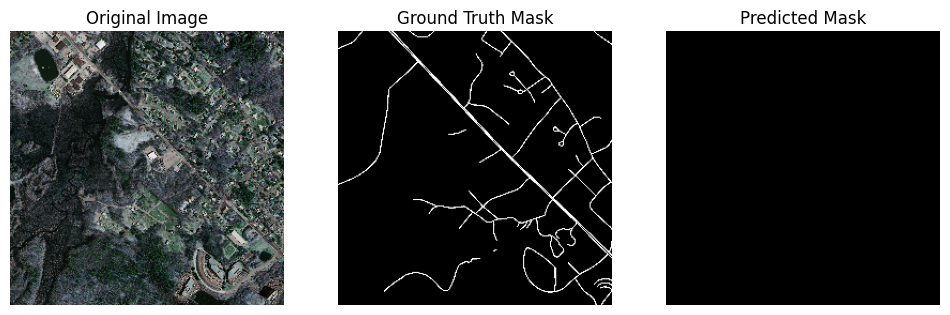

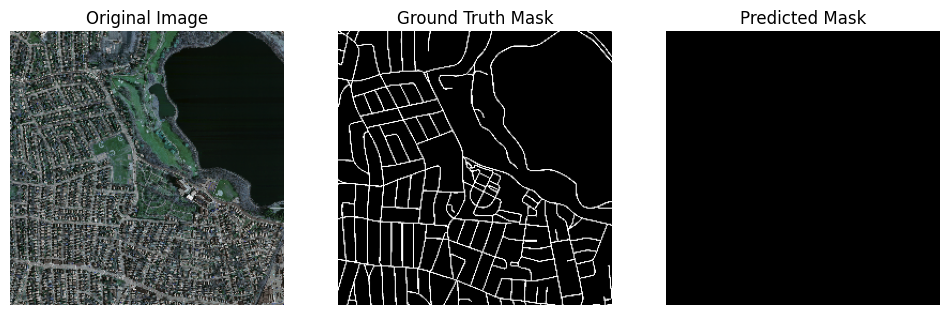

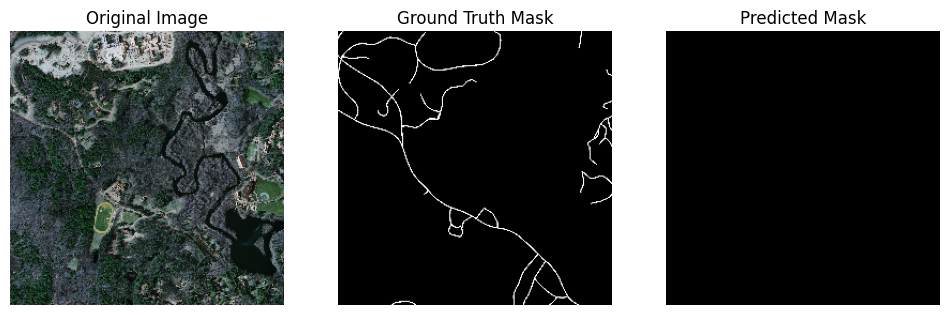

In [ ]:
import random
import matplotlib.pyplot as plt

# Show random samples from validation set
num_samples = 3
indices = random.sample(range(len(X_val)), num_samples)

for idx in indices:
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[idx])
    plt.title("Original Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(preds[idx].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [ ]:
print("Unique values in y_train:", np.unique(y_train))


Unique values in y_train: [0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549
 0.14117647 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431
 0.16470588 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373
 0.18823529 0.19215686 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196
 0.25882353 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137
 0.28235294 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078
 0.30588235 0.30980392 0.31372549 0.31764706 0.32156863 0.3254902
 0.32941176 0.33333333 0.3372549  0.34

# solve problem

X_train shape: (1108, 256, 256, 3)
y_train shape: (1108, 256, 256, 1)
X_val shape: (14, 256, 256, 3)
y_val shape: (14, 256, 256, 1)
Unique y_train values: [0 1]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8997 - loss: 0.3240
Epoch 1: val_loss improved from inf to 0.22298, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.9003 - loss: 0.3228 - val_accuracy: 0.9309 - val_loss: 0.2230 - learning_rate: 0.0010
Epoch 2/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9521 - loss: 0.1732
Epoch 2: val_loss improved from 0.22298 to 0.21349, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9521 - loss: 0.1731 - val_accuracy: 0.9309 - val_loss: 0.2135 - learning_rate: 0.0010
Epoch 3/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9526 - loss: 0.1604
Epoch 3: val_loss improved from 0.21349 to 0.19957, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9526 - loss: 0.1604 - val_accuracy: 0.9309 - val_loss: 0.1996 - learning_rate: 0.0010
Epoch 4/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9523 - loss: 0.1541
Epoch 4: val_loss did not improve from 0.19957
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9523 - loss: 0.1541 - val_accuracy: 0.9317 - val_loss: 0.2021 - learning_rate: 0.0010
Epoch 5/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9525 - loss: 0.1481
Epoch 5: val_loss improved from 0.19957 to 0.18617, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9525 - loss: 0.1480 - val_accuracy: 0.9332 - val_loss: 0.1862 - learning_rate: 0.0010
Epoch 6/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9543 - loss: 0.1440
Epoch 6: val_loss improved from 0.18617 to 0.17650, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9543 - loss: 0.1439 - val_accuracy: 0.9362 - val_loss: 0.1765 - learning_rate: 0.0010
Epoch 7/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9565 - loss: 0.1355
Epoch 7: val_loss improved from 0.17650 to 0.17329, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9565 - loss: 0.1355 - val_accuracy: 0.9381 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 8/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9597 - loss: 0.1262
Epoch 8: val_loss improved from 0.17329 to 0.16196, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9596 - loss: 0.1263 - val_accuracy: 0.9418 - val_loss: 0.1620 - learning_rate: 0.0010
Epoch 9/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9602 - loss: 0.1238
Epoch 9: val_loss improved from 0.16196 to 0.15776, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9602 - loss: 0.1238 - val_accuracy: 0.9435 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 10/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9588 - loss: 0.1273
Epoch 10: val_loss improved from 0.15776 to 0.15223, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9589 - loss: 0.1272 - val_accuracy: 0.9452 - val_loss: 0.1522 - learning_rate: 0.0010
Epoch 11/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9600 - loss: 0.1240
Epoch 11: val_loss improved from 0.15223 to 0.14867, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9600 - loss: 0.1239 - val_accuracy: 0.9470 - val_loss: 0.1487 - learning_rate: 0.0010
Epoch 12/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9626 - loss: 0.1168
Epoch 12: val_loss improved from 0.14867 to 0.14287, saving model to unet_best_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9626 - loss: 0.1169 - val_accuracy: 0.9483 - val_loss: 0.1429 - learning_rate: 0.0010
Epoch 13/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9197 - loss: 5.2525
Epoch 13: val_loss did not improve from 0.14287
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9190 - loss: 5.4256 - val_accuracy: 0.9290 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 14/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9030 - loss: 3.3031
Epoch 14: val_loss did not improve from 0.14287
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9037 - loss: 3.2584 - val_accuracy: 0.9309 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 15/30
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9525 - loss: 0.5528
Epoch 15: val_loss did not improve from 0.14287
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9525 - loss: 0.5524 - val_accuracy: 0.9309 - val_loss: 0.5240 - learning_rate: 0.0010
Epoch 16/30
69/70 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(14, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


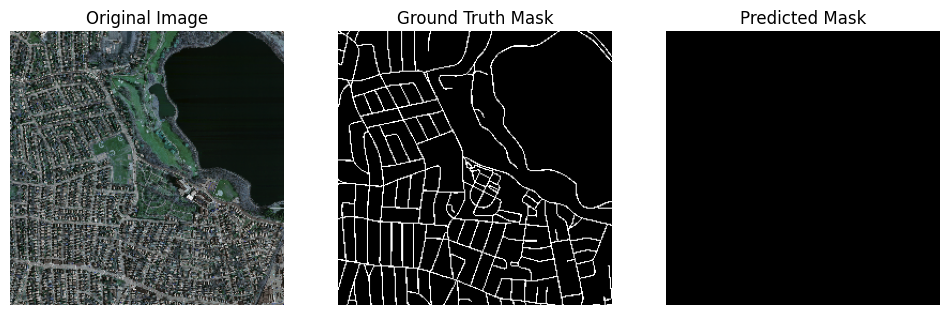

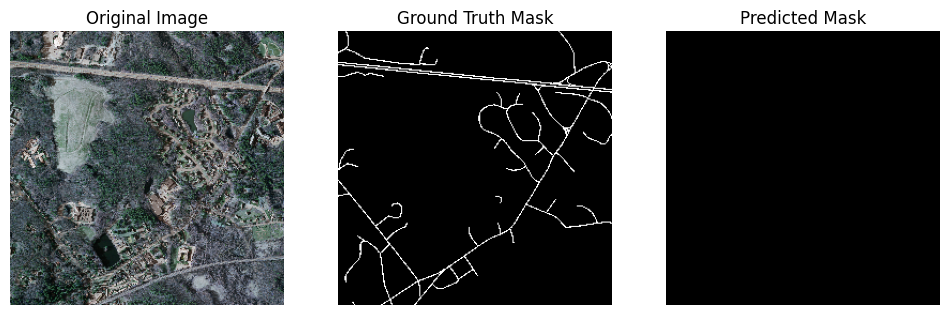

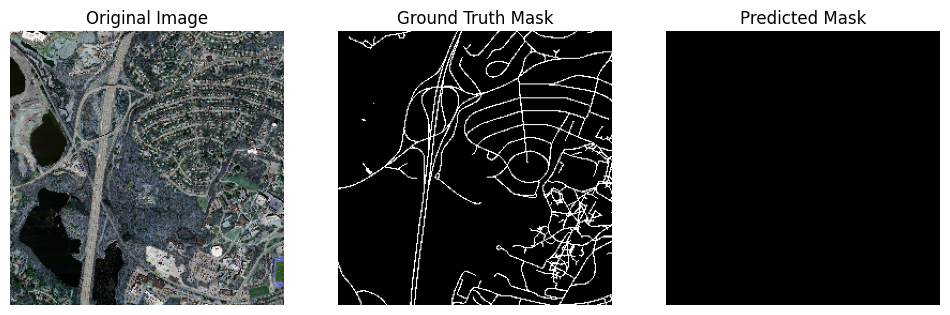

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# --------- إعداد البيانات ---------
IMG_SIZE = 256

def load_images_and_masks(image_dir, mask_dir, img_size):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        # Read and resize image
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0  # Normalize to [0, 1]

        # Read and resize mask (as grayscale)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.0  # Normalize to [0, 1]
        mask = (mask > 0.5).astype(np.uint8)  # 🔥 Make binary
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# --------- بناء نموذج U-Net ---------
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --------- تحميل البيانات ---------
train_image_dir = "/content/road_data/tiff/train"
train_mask_dir = "/content/road_data/tiff/train_labels"
val_image_dir = "/content/road_data/tiff/val"
val_mask_dir = "/content/road_data/tiff/val_labels"

X_train, y_train = load_images_and_masks(train_image_dir, train_mask_dir, IMG_SIZE)
X_val, y_val = load_images_and_masks(val_image_dir, val_mask_dir, IMG_SIZE)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print("Unique y_train values:", np.unique(y_train))

# --------- تدريب النموذج ---------
input_shape = (IMG_SIZE, IMG_SIZE, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

checkpoint = ModelCheckpoint("unet_best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, reduce_lr]
)

# --------- التنبؤ والعرض ---------
preds = unet_model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)

# عرض عينات عشوائية
num_samples = 3
indices = random.sample(range(len(X_val)), num_samples)

for idx in indices:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[idx])
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[idx].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


# solve problem 2

X_train shape: (1108, 256, 256, 3)
y_train shape: (1108, 256, 256, 1)
Unique mask values: [0 1]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_10… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_44[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_11… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_46[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │  2,097,664 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3888 - loss: 0.8812
Epoch 1: val_loss improved from inf to 0.71355, saving model to unet_best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.3898 - loss: 0.8811 - val_accuracy: 0.8122 - val_loss: 0.7135 - learning_rate: 0.0010
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8483 - loss: 0.9492
Epoch 2: val_loss did not improve from 0.71355
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8488 - loss: 0.9495 - val_accuracy: 0.9309 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 3/50
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9536 - loss: 1.0000
Epoch 3: val_loss did not improve from 0.71355
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9535 - loss: 1.0000 - val_accuracy: 0.9309 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9515 - loss: 1.0000
Epoch 4: val_loss did not improve from 0.71355
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9515 - loss: 1.0000 - val_accuracy: 0.9309 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 5/50
138/139 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(14, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


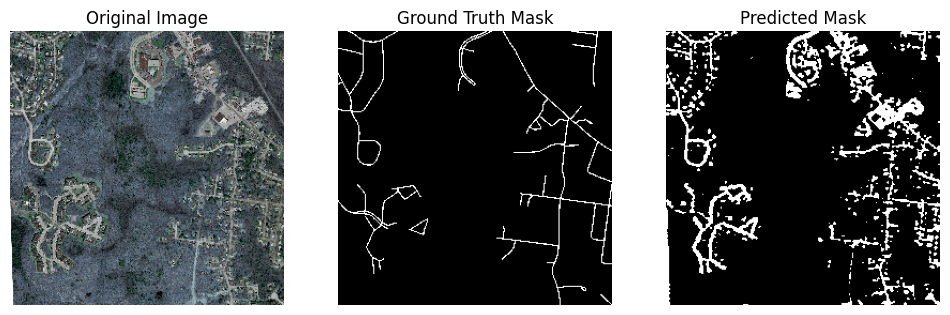

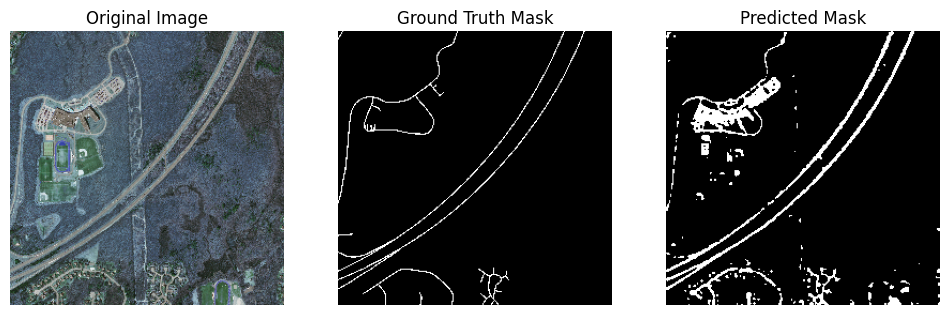

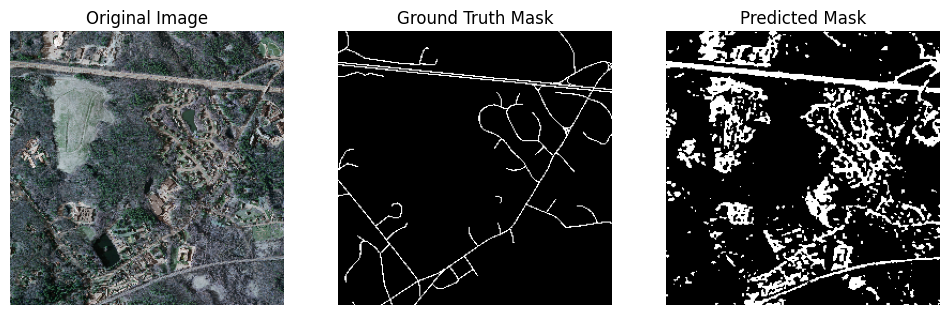

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# --------- إعداد ثابت ---------
IMG_SIZE = 256

# --------- تحميل الصور والأقنعة ---------
def load_images_and_masks(image_dir, mask_dir, img_size):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0  # Normalize image

        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.0  # Normalize mask
        mask = (mask > 0.5).astype(np.uint8)  # 🔥 Make binary
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# --------- Dice Loss ---------
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# --------- بناء U-Net ---------
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --------- تحميل البيانات ---------
train_image_dir = "/content/road_data/tiff/train"
train_mask_dir = "/content/road_data/tiff/train_labels"
val_image_dir = "/content/road_data/tiff/val"
val_mask_dir = "/content/road_data/tiff/val_labels"

X_train, y_train = load_images_and_masks(train_image_dir, train_mask_dir, IMG_SIZE)
X_val, y_val = load_images_and_masks(val_image_dir, val_mask_dir, IMG_SIZE)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("Unique mask values:", np.unique(y_train))

# --------- إعداد النموذج ---------
input_shape = (IMG_SIZE, IMG_SIZE, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
unet_model.summary()

# --------- إعداد الكول باكس ---------
checkpoint = ModelCheckpoint("unet_best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --------- تدريب ---------
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# --------- التنبؤ والعرض ---------
preds = unet_model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)

# عرض عينات
num_samples = 3
indices = random.sample(range(len(X_val)), num_samples)

for idx in indices:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[idx])
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[idx].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()
